In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import os
import h5py
import matplotlib.pyplot as plt

1. Load received SQLite file: database.db .

Importing data

In [2]:

data_path = 'data/database.db'
if not os.path.exists(data_path):
    raise()

conn = sql.connect(data_path)

c = conn.cursor()

tablenames = [t  for t in c.execute("SELECT sql,name FROM sqlite_master WHERE type='table';")]
tablenames

[('CREATE TABLE data (\n    id INTEGER PRIMARY KEY,\n    x REAL,\n    y TEXT,\n    z REAL,\n    connection_id INTEGER,\n    FOREIGN KEY(connection_id) REFERENCES connection(id)\n)',
  'data'),
 ('CREATE TABLE connection (\n    id INTEGER PRIMARY KEY,\n    name TEXT\n)',
  'connection'),
 ('CREATE TABLE additional_data (\n    color_id INTEGER PRIMARY KEY,\n    color_name TEXT\n)',
  'additional_data')]

In [3]:
data_d = [t  for t in c.execute("SELECT * from data")]

connection_d = [t  for t in c.execute("SELECT * from connection")]

additional_data_d = [t  for t in c.execute("SELECT * from additional_data")]

Little review

In [4]:
print(data_d[:5])
print('-'*100)

print(connection_d[:5])
print('-'*100)

print(additional_data_d[:5])
print('-'*100)

print(len(data_d))
print(len(connection_d))
print(len(additional_data_d))
print(len(set(data_d)))
print(len(set(connection_d)))
print(len(set(additional_data_d)))
# hmm

[(1, 44.62894693090455, '97.81099110033537', 569.7004532585571, 105), (2, 40.764309055564155, '82.0486367746882', 653.9040637023857, 76), (3, 25.849509311338426, '63.29510234435348', 374.1711758229815, 72), (4, 18.973395754992428, '50.59596955801666', 440.9766346304599, 239), (5, 44.7876215662726, '39.347747208411256', 219.38896277499066, 152)]
----------------------------------------------------------------------------------------------------
[(2, 'blue'), (4, 'blue'), (9, 'blue'), (10, 'blue'), (15, 'blue')]
----------------------------------------------------------------------------------------------------
[(0, 'red'), (2, 'blue'), (3, 'yellow'), (4, 'orange'), (5, 'black')]
----------------------------------------------------------------------------------------------------
101300
36
6
101300
36
6


2. The database.db file contains several tables. Use them to create Pandas DataFrame with x , y , z , color_id and color_name for every record.

Ok, straight to dataframe.

In [5]:
sql_querry= '''
SELECT d.x, d.y, d.z, ad.color_id, ad.color_name 
from data d 
left join connection c 
on d.connection_id =c.id 
left join additional_data ad
on ad.color_name = c.name
'''
df_data = pd.read_sql_query(sql_querry, conn)
conn.close()

In [6]:
df_data.head()

,x,y,z,color_id,color_name
0,44.628947,97.81099110033537,569.700453,11.0,green
1,40.764309,82.0486367746882,653.904064,4.0,orange
2,25.849509,63.29510234435348,374.171176,4.0,orange
3,18.973396,50.59596955801666,440.976635,3.0,yellow
4,44.787622,39.347747208411256,219.388963,0.0,red


In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101300 entries, 0 to 101299
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   x           101300 non-null  float64
 1   y           101300 non-null  object 
 2   z           101300 non-null  float64
 3   color_id    101200 non-null  float64
 4   color_name  101200 non-null  object 
dtypes: float64(3), object(2)
memory usage: 3.9+ MB


Seems we have 100 NaNs inside, lack of connection inside database? Should use fulljoin 


3. Note, that x, y, z should be converted to floating-point format (if necessary), and color_id to integers.

Noted.

4. All invalid record should be removed.

In [8]:
df_data.dropna(inplace=True)
df_data.color_id = pd.to_numeric(df_data.color_id).astype(int)
df_data.y = df_data.y.astype('float64')
df_data.dropna(inplace=True)
df_data.info()

# before dropna there was string like 'qqedsfgrtrtry' in Y column, its magic gone.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101200 entries, 0 to 101299
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   x           101200 non-null  float64
 1   y           101200 non-null  float64
 2   z           101200 non-null  float64
 3   color_id    101200 non-null  int32  
 4   color_name  101200 non-null  object 
dtypes: float64(3), int32(1), object(1)
memory usage: 4.2+ MB


5. Change color_name column to color .

In [9]:
df_data.rename(columns={'color_name':'color'}, errors='raise',inplace=True)

df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101200 entries, 0 to 101299
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   x         101200 non-null  float64
 1   y         101200 non-null  float64
 2   z         101200 non-null  float64
 3   color_id  101200 non-null  int32  
 4   color     101200 non-null  object 
dtypes: float64(3), int32(1), object(1)
memory usage: 4.2+ MB


6. List unique color values.

In [10]:
# its in here:
print(additional_data_d)
# but i guess you want me to print it from df

list(df_data.color.unique())

[(0, 'red'), (2, 'blue'), (3, 'yellow'), (4, 'orange'), (5, 'black'), (11, 'green')]


['green', 'orange', 'yellow', 'red', 'black', 'blue']

7. Leave only data with z = 100 .

In [11]:
df_data = df_data[df_data.z== 100.]

df_data.z = pd.to_numeric(df_data.z).astype(int)

In [12]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 123 to 101223
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         1200 non-null   float64
 1   y         1200 non-null   float64
 2   z         1200 non-null   int32  
 3   color_id  1200 non-null   int32  
 4   color     1200 non-null   object 
dtypes: float64(2), int32(2), object(1)
memory usage: 46.9+ KB


8. Remove red points with a distance from average red points’ position above 1 sigma.

In [13]:
sd = df_data.std(axis=0)
mean = df_data.mean(axis=0)
print('-'*100,'\nsd:')
print(sd)
print('-'*100,'\nmean:')
print(mean)
df_data.describe()

---------------------------------------------------------------------------------------------------- 
sd:
x           1.132845
y           0.170310
z           0.000000
color_id    2.597822
dtype: float64
---------------------------------------------------------------------------------------------------- 
mean:
x          -4.181840e-17
y          -3.011846e-01
z           1.000000e+02
color_id    2.583333e+00
dtype: float64


,x,y,z,color_id
count,1.200000e+03,1200.000000,1200.0,1200.000000
mean,-4.181840e-17,-0.301185,100.0,2.583333
std,1.132845e+00,0.170310,0.0,2.597822
min,-2.000000e+00,-0.499429,100.0,0.000000
25%,-9.997543e-01,-0.423163,100.0,2.000000
50%,1.110223e-16,-0.359612,100.0,2.000000
75%,9.997543e-01,-0.255293,100.0,2.000000
max,2.000000e+00,0.099224,100.0,11.000000


In [14]:
sigma = 1


reds_to_remove_1 = df_data[((df_data.x<(mean[0] + sigma*sd[0]))
                            | (df_data.y<(mean[1] + sigma*sd[1]))) 
                         & (df_data.color_id ==0)]

reds_to_remove_1.info()

reds_to_remove_2 = df_data[(df_data.x<(mean[0] + sigma*sd[0])) 
                         & (df_data.y<(mean[1] + sigma*sd[1])) 
                         & (df_data.color_id ==0)]

reds_to_remove_2.info()


print(len(df_data[(df_data.color_id ==0)]))

#weird, we dont want to delete all reds. So i will take second one, because smile at end will endup with one eye.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 995 to 100892
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         100 non-null    float64
 1   y         100 non-null    float64
 2   z         100 non-null    int32  
 3   color_id  100 non-null    int32  
 4   color     100 non-null    object 
dtypes: float64(2), int32(2), object(1)
memory usage: 3.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         0 non-null      float64
 1   y         0 non-null      float64
 2   z         0 non-null      int32  
 3   color_id  0 non-null      int32  
 4   color     0 non-null      object 
dtypes: float64(2), int32(2), object(1)
memory usage: 0.0+ bytes
100


In [16]:
df_final = df_data[~df_data.index.isin(reds_to_remove_2.index)]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 123 to 101223
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         1200 non-null   float64
 1   y         1200 non-null   float64
 2   z         1200 non-null   int32  
 3   color_id  1200 non-null   int32  
 4   color     1200 non-null   object 
dtypes: float64(2), int32(2), object(1)
memory usage: 46.9+ KB


9. Make sure rows indices are consecutive integers (starting from 0).

In [17]:
df_final.reset_index(drop=True,inplace=True)

In [18]:
df_final.head()

,x,y,z,color_id,color
0,-0.850851,-0.441336,100,2,blue
1,-0.458458,-0.401101,100,2,blue
2,-1.667668,-0.329684,100,2,blue
3,0.394394,-0.439959,100,2,blue
4,1.703704,-0.316621,100,2,blue


10. Save the remaining points in a HDF5 file with dataset ns1 containing columns: x, y,color.

In [19]:
hdf5_file_path = 'data/ns1.h5'
df_final[['x','y','color']].to_hdf(hdf5_file_path,'ns1',mode='w',format='table',data_columns=True)

11. Plot data from the HDF5 file using scatter plot (with corresponding colors).

In [20]:
df = pd.read_hdf(hdf5_file_path)

In [21]:
df.head()

,x,y,color
0,-0.850851,-0.441336,blue
1,-0.458458,-0.401101,blue
2,-1.667668,-0.329684,blue
3,0.394394,-0.439959,blue
4,1.703704,-0.316621,blue


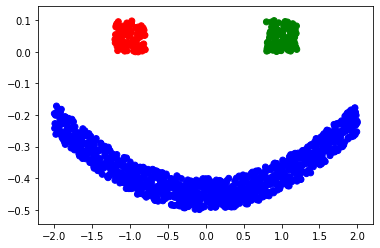

In [22]:
plt.scatter(x=df.x,y=df.y,c=df.color)

# :)